In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

Let's solve the Poisson equation in 2D using cvPINNs

\begin{equation}
\begin{matrix}
\nabla \cdot \nabla u = f = xy-\frac{1}{4} & x,y \in \Omega = [0,1]\times[0,1]\\
\nabla u\cdot n = 0 & x,y \in \partial \Omega\\
u(x=0,y=0) = 0
\end{matrix}
\end{equation}

If we discretize our domain on an $N\times N$ rectangular grid, we can integrate over each cell and apply the divergence theorem. Let's index each cell, $c_{ij}$, with $i$ for $x$ and $j$ for $y$.

\begin{equation}
\begin{matrix}
\int_{c_{ij}} \nabla \cdot \nabla u dc = \Delta_x \Delta_y f_{ij}\\ 
\int_{\partial c_{ij}}  \nabla u \cdot dn = \Delta_x \Delta_y f_{ij}
\end{matrix}
\end{equation}

If we approximate the value at each cell boundary by its midpoint, 

\begin{equation}
\begin{matrix}
\Delta_x \left(\partial_x u|_{i+\frac{1}{2},j} - \partial_x u|_{i-\frac{1}{2},j}\right) + \Delta_y \left(\partial_y u|_{i+\frac{1}{2},j} - \partial_y u|_{i-\frac{1}{2},j}\right) - \Delta_x \Delta_y f_{ij} = 0 
\end{matrix}
\end{equation}

We get the following staggered grid,

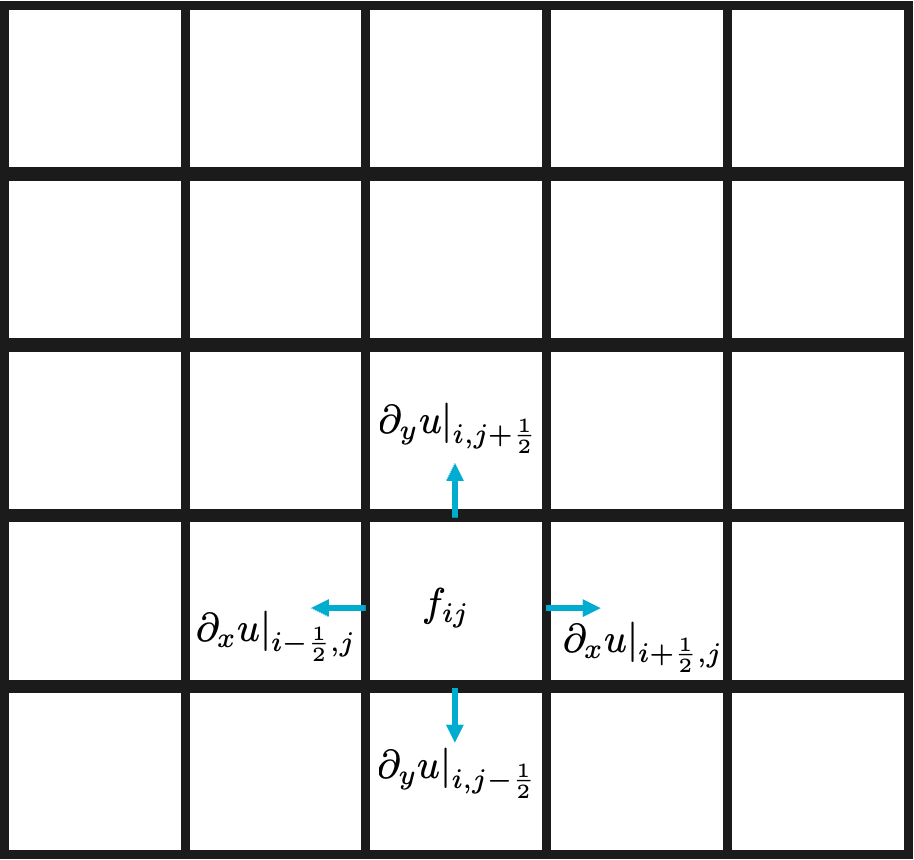

In [ ]:
# Let's build the grids. We'll have two staggered grids, one for the gradients in x and one for y
# We'll only include points in the interior. This time, we won't flatten the array of points so that
# we can more easily pad for the boundary conditions

N = 100
delta = 1./100
x = np.linspace(delta,1-delta,N-1)
y = np.linspace(delta,1-delta,N-1)
m=np.arange(100)*delta+delta/2

xs_ = np.meshgrid(x,m,indexing='ij')
ys_ = np.meshgrid(m,y,indexing='ij')
ms_ = np.meshgrid(m,m,indexing='ij')

xs = np.stack(xs_,axis=-1).astype('float32')
ys = np.stack(ys_,axis=-1).astype('float32')
ms = np.stack(ms_,axis=-1).astype('float32')


In [ ]:
#Makes a neural network to represent the solution
class U(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.build(2)
        self.Z = tf.zeros((1,1,2))
    def build(self,input_shape):
        layers =     [tf.keras.layers.Dense(10,activation='elu') for _ in range(6)] \
                    + [tf.keras.layers.Dense(1)]
        self.model = tf.keras.models.Sequential(layers)
        
    def call(self,x):
        #we fix u(x=0,y=0)=0
        return self.model(x)-self.model(self.Z)
u = U()
u(xs)
u.summary()

In [ ]:
#PDE residual. `persistent` lets you resuse the tape. We'll need it for both grids
#we include the boundary conditions by padding zeros where the gradients are at the
#boundaries

@tf.function
def PDE_res(xs,ys):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xs)
        tape.watch(ys)
        u_x = u(xs)
        u_y = u(ys)
    #we only need the x component of the gradient for the x staggered grid
    du_x = tape.gradient(u_x,xs)[...,0]
    du_y = tape.gradient(u_y,ys)[...,1]
    du_x = tf.pad(du_x,[[1,1],[0,0]])
    du_y = tf.pad(du_y,[[0,0],[1,1]])
    f = ms[...,0]*ms[...,1]-.25
    return tf.reduce_sum(((du_x[1:]-du_x[0:-1]) + (du_y[:,1:]-du_y[:,0:-1]) - f*delta)**2)        

In [ ]:
opt = tf.keras.optimizers.Adam(1e-3)
@tf.function
def train():
    with tf.GradientTape() as tape:
        tape.watch(u.trainable_variables)
        res_ = PDE_res(xs,ys)
    grad_ = tape.gradient(res_,u.trainable_variables)
    opt.apply_gradients(zip(grad_,u.trainable_variables))
    return res_

In [ ]:
for _ in range(1000):
    print(train().numpy())

In [ ]:
plt.imshow(u(xs)[...,0]);plt.colorbar()

In [ ]:
#Laplacian of solution should equal RHS. This is the true RHS

plt.imshow(ms[...,0]*ms[...,1]-.25,vmin=-.2,vmax=.8)
plt.colorbar()

In [ ]:
#this is the Laplacian of the CVPINNs solution. A side effect of working with this 
#integral form is that we enforce less regularity in u. 

@tf.function
def Laplacian(ms):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(ms)
        with tf.GradientTape() as tape1:
            tape1.watch(ms)
            u_ = u(ms)
        du_x,du_y = tf.split(tape1.gradient(u_,ms),[1,1],axis=-1)
    return tape2.gradient(du_x,ms)[...,0] + tape2.gradient(du_y,ms)[...,1]
plt.imshow(Laplacian(ms),vmin=-.2,vmax=.8)
plt.colorbar()